In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
import seaborn as sns

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv


In [2]:
data = pd.read_csv("../input/metro-interstate-traffic-volume/Metro_Interstate_Traffic_Volume.csv")
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
data['date_time'] = pd.to_datetime(data['date_time'])
data['month'] = data['date_time'].dt.month
data['dayofweek'] = data['date_time'].dt.dayofweek
data['hour'] = data['date_time'].dt.hour
data['year'] = data['date_time'].dt.year
data.drop(['rain_1h', 'snow_1h', 'clouds_all', 'weather_main','weather_description'], inplace = True, axis=1)

# EDA

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00
month,48204.0,6.506037,3.400221,1.0,4.00,7.00,9.000,12.00
dayofweek,48204.0,2.984980,2.005941,0.0,1.00,3.00,5.000,6.00
hour,48204.0,11.398162,6.940238,0.0,5.00,11.00,17.000,23.00
year,48204.0,2015.512426,1.893211,2012.0,2014.00,2016.00,2017.000,2018.00


array([[<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'date_time'}>,
        <AxesSubplot:title={'center':'traffic_volume'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'dayofweek'}>,
        <AxesSubplot:title={'center':'hour'}>],
       [<AxesSubplot:title={'center':'year'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

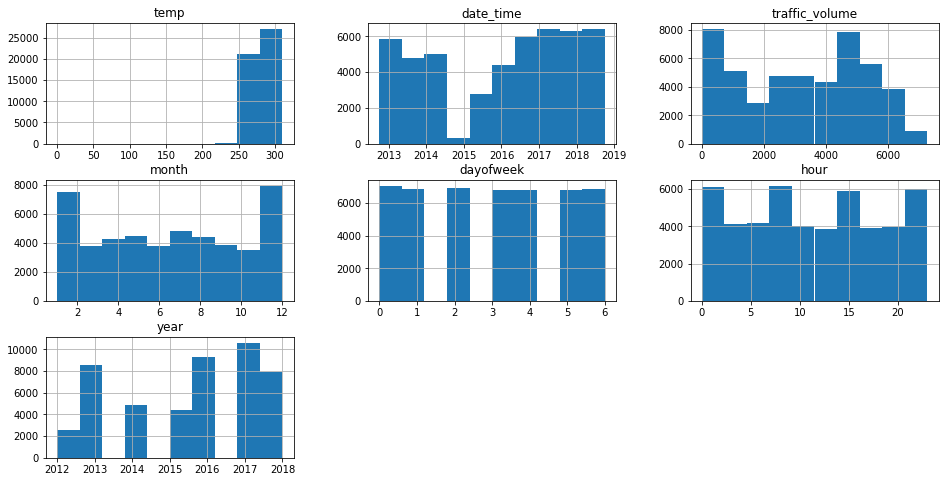

In [5]:
data.hist(figsize=(16,8))

Из гистограм:
1) Что-то не так в 2015 году. Мало данных.

2) Поо часам анные тоже не равномерны. Возможны пропуски или дубликаты.

In [6]:
# посмотрим на кореляцию трафика. 
data.corr()['traffic_volume']

temp              0.130299
traffic_volume    1.000000
month            -0.002533
dayofweek        -0.149544
hour              0.352401
year              0.004753
Name: traffic_volume, dtype: float64

Некоторые наальные грубые приближения можно даже и сделать. Например, нет особой необходимости смотреть на год, потому что тред по годам небольшой. При этом можно сократить данные последним годом, например.

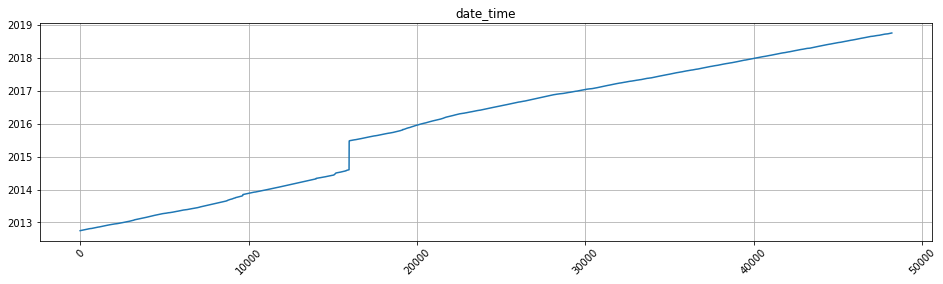

In [7]:
def plot_data(df, title=""):
    df.plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.title(title)
    plt.grid(True)
    plt.show()
    
#Посмотрим детально на время.
plot_data(data.loc[:,'date_time'],"date_time")

Видим разры по метке времени. Посмотрим поближе.

In [8]:
data.loc[15969:15972,'date_time']

15969   2014-08-08 00:00:00
15970   2014-08-08 01:00:00
15971   2015-06-11 20:00:00
15972   2015-06-12 18:00:00
Name: date_time, dtype: datetime64[ns]

Разрыв почти на год. Интерполировать на годовом промежутке -дело неблагодарное. Нщё один повод выбросить первые несколько лет наблюдений. 

In [9]:
data_last_years = data[data['year'] > 2016].copy()
data_last_years.reset_index(inplace=True, drop=True)
print(data.shape, data_last_years.shape)

(48204, 8) (18554, 8)


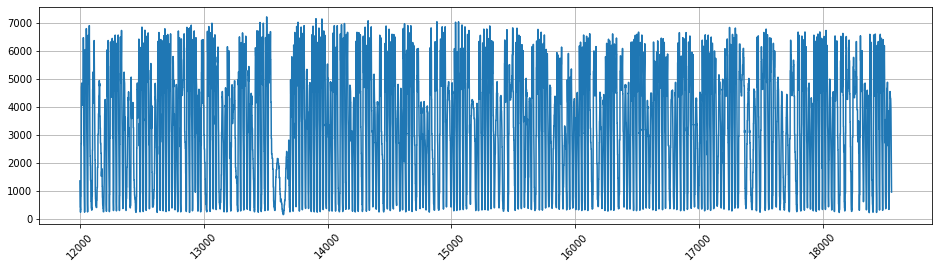

In [10]:
plot_data(data_last_years.loc[12000:,'traffic_volume'])

In [11]:
# Проверка на дубли
print(data_last_years.date_time.duplicated().sum())

# Убийство дублей, контрольная провкерка
data_last_years.drop_duplicates(subset=['date_time'], keep='last', inplace=True)
data_last_years.reset_index(inplace=True, drop=True)

print(data_last_years.date_time.duplicated().sum())

3308
0


In [12]:
data_last_years

,holiday,temp,date_time,traffic_volume,month,dayofweek,hour,year
0,None,269.75,2017-01-01 00:00:00,1848,1,6,0,2017
1,None,269.95,2017-01-01 01:00:00,1806,1,6,1,2017
2,None,269.75,2017-01-01 02:00:00,1211,1,6,2,2017
3,None,269.65,2017-01-01 03:00:00,794,1,6,3,2017
4,None,269.48,2017-01-01 04:00:00,500,1,6,4,2017
...,...,...,...,...,...,...,...,...
15241,None,283.45,2018-09-30 19:00:00,3543,9,6,19,2018
15242,None,282.76,2018-09-30 20:00:00,2781,9,6,20,2018
15243,None,282.73,2018-09-30 21:00:00,2159,9,6,21,2018
15244,None,282.09,2018-09-30 22:00:00,1450,9,6,22,2018


In [13]:
# проверим на равномерность временных меток
# Возьмем первую и последню запись и сгенерим временной ряд с шагом 1 час.

first_date = data_last_years.loc[0, 'date_time']
last_date = data_last_years.loc[data_last_years.shape[0]-1, 'date_time'] 
print("Начало отсчета: ", first_date, "Конец отсчета:", last_date)
print("Интевал:", last_date - first_date)

dates = pd.date_range(start=first_date, end=last_date, freq='h')

print("Количество записей в датафрейме:", len(data_last_years))
print("Количество записей (часов) в сгенерированном временном ряде:", len(dates))

Начало отсчета:  2017-01-01 00:00:00 Конец отсчета: 2018-09-30 23:00:00
Интевал: 637 days 23:00:00
Количество записей в датафрейме: 15246
Количество записей (часов) в сгенерированном временном ряде: 15312


In [14]:
# Данных по каждому часу
data_last_years.hour.value_counts()

14    638
1     638
0     637
11    637
22    637
21    637
20    637
19    637
18    637
13    637
12    637
10    636
15    636
16    636
17    636
23    636
6     634
5     634
4     634
9     633
8     633
7     633
3     633
2     623
Name: hour, dtype: int64

Есть пропуски в данных!

In [15]:
# Создадим датаффреейм из сгенерированного временного ряда.
dates_df = pd.DataFrame(dates, columns=['date_time'])

# Сложим два датафрйма, по date_time 
sm_df = dates_df.merge(data_last_years, how='left',on ='date_time')

# Опять появляются дубли.
#sm_df.drop_duplicates(subset=['date_time'], keep='last', inplace=True)
#m_df.reset_index(inplace=True, drop=True)

print(dates_df.shape, sm_df.shape)

(15312, 1) (15312, 8)


In [16]:
# Там, где были пропуски в date_time теперь пропущенные значения
sm_df.isna().sum()

date_time          0
holiday           66
temp              66
traffic_volume    66
month             66
dayofweek         66
hour              66
year              66
dtype: int64

In [17]:
# traffic_volum, temp линейно интерполируем. Восстановим дни, часы итд.
sm_df['traffic_volume'] = sm_df['traffic_volume'].interpolate(method='linear')
sm_df['temp'] = sm_df['temp'].interpolate(method='linear')
sm_df['holiday'] = sm_df['holiday'].fillna(method="ffill")

sm_df['month'] = sm_df['date_time'].dt.month
sm_df['dayofweek'] = sm_df['date_time'].dt.dayofweek
sm_df['hour'] = sm_df['date_time'].dt.hour
sm_df['year'] = sm_df['date_time'].dt.year

sm_df.isna().sum()

date_time         0
holiday           0
temp              0
traffic_volume    0
month             0
dayofweek         0
hour              0
year              0
dtype: int64

In [18]:
sm_df.set_index('date_time', inplace=True)

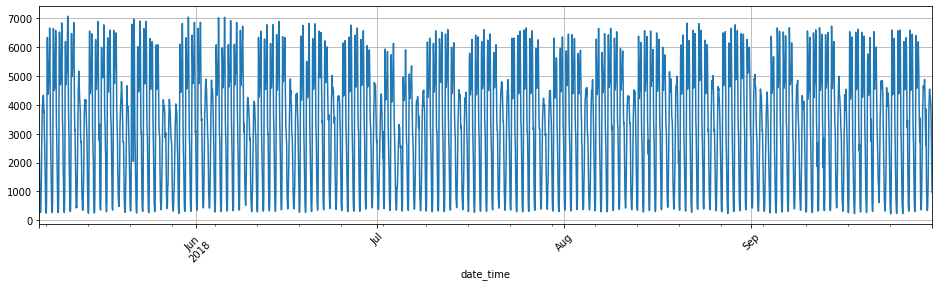

In [19]:
# Посмотрим на данные. Причёсанные и приглаженные. Возьмем случайный кусок.
plot_data(sm_df.loc['2018-05-05 23:00:00':,'traffic_volume'])

In [20]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sm_df, test_size=14*24, shuffle=False)

print(train_df.shape, test_df.shape)

(14976, 7) (336, 7)


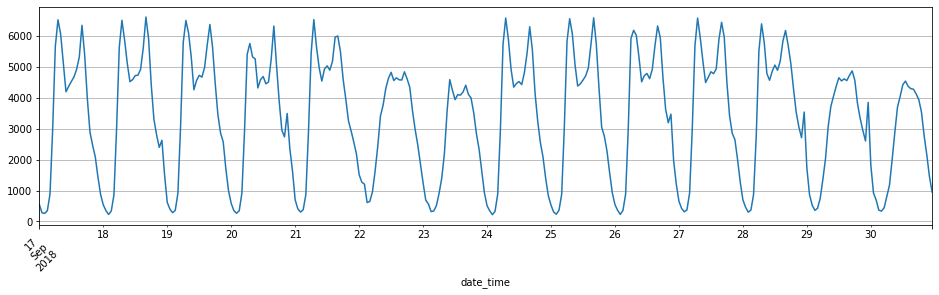

In [21]:
# Посомотрим, что нам предстоит предсказывать
plot_data(test_df.loc[:,'traffic_volume'])

# 1. Forecast by means

In [22]:
# Посмотри на средние по времени
tr_mean = train_df.groupby(["dayofweek", "hour"])["traffic_volume"].mean()
tr_mean

dayofweek  hour
0          0        664.348315
           1        409.314607
           2        309.258427
           3        356.438202
           4        821.022472
                      ...     
6          19      3190.922222
           20      2873.266667
           21      2435.377778
           22      1876.000000
           23      1276.755556
Name: traffic_volume, Length: 168, dtype: float64

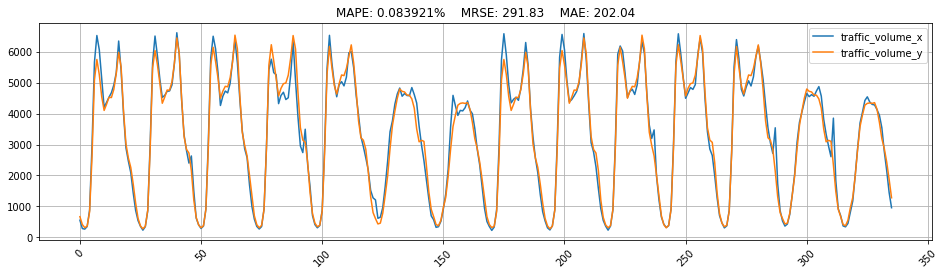

In [23]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

test_pred = test_df.merge(tr_mean, how='left',on = ["dayofweek", "hour"])
#test_pred.set_index('date_time', inplace=True)

mape = mean_absolute_percentage_error(test_pred['traffic_volume_x'], test_pred['traffic_volume_y'])
mae = mean_absolute_error(test_pred['traffic_volume_x'], test_pred['traffic_volume_y'])
mrse = mean_squared_error(test_pred['traffic_volume_x'], test_pred['traffic_volume_y'], squared=False)

test_pred[['traffic_volume_x','traffic_volume_y']].plot(figsize=(16,4))
plt.xticks(rotation=45)
plt.title("MAPE: {0:2f}%    MRSE: {1:.2f}    MAE: {2:.2f}".format(mape,mrse, mae))
plt.grid(True)
plt.show()


Предсказание с использванием средних дало столь высокие результаты, что лучшего и желать трудно)) Но мы попробуем.

In [24]:
# Добавим текущий результат в копилку для сравнения
results = []
results.append(["Forecast by means", mape])


# 2. Lags usage. Linear and catboost models.

In [25]:
# Useful functions

def create_lags(df, series_columns, start_lag, end_lag):
    data = df.copy()
    for c in series_columns:
        for i in range(start_lag, end_lag):
            #data["lag_{}_{}".format(c, i)] = data[c].shift(i)
            data["lag_{}".format(i)] = data[c].shift(i)
    return data


def recursive_predict(model, df_forecast):
    horizon = len(df_forecast)
    
    df_pred = df_forecast.copy().reset_index().drop('date_time', axis=1)
    #print(df_pred.iloc[[i], :])
    #print(df_pred.isna().sum())
    
    #df_pred.iloc[1:] = np.nan
    #print(df_pred)
    forecast = []
    for i in range(horizon):
        next_x = model.predict(df_pred.iloc[[i], :])[0]
        if i < horizon-1:
            df_pred.iloc[i+1,6] = next_x
            df_pred.iloc[[i+1],7:] = df_pred.iloc[i,6:-1].values
        
        #print(i)
        #print(df_pred.head())
        forecast.append(next_x)
    
    return np.array(forecast)


def plotRecursivePrediction(model, X_test, y_test):
    prediction = recursive_predict(model, X_test)
    
    plt.figure(figsize=(16, 4))
    
    error = mean_absolute_percentage_error(prediction, y_test.values)
    plt.title("Mean absolute percentage error {0:.3f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)
    
    return error


def plotPrediction(y_test, y_forecast):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.3f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.get_feature_importance(), X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [26]:
sm_df['holiday'] = sm_df['holiday'].apply(lambda a: 0 if a == "None" else 1)

In [27]:
sm_df_lags = create_lags(sm_df, ["traffic_volume"], 1, 48)
sm_df_lags = sm_df_lags.dropna(axis=0)

In [28]:
y = sm_df_lags.pop("traffic_volume")

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(sm_df_lags, y, test_size=14*24, shuffle=False)

X_test_df.head(3)

,holiday,temp,month,dayofweek,hour,year,lag_1,lag_2,lag_3,lag_4,...,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47
date_time,,,,,,,,,,,,,,,,,,,,,
2018-09-17 00:00:00,0,296.58,9,0,0,2018,1088.0,1725.0,2623.0,3092.0,...,4448.0,3999.0,3442.0,2117.0,1469.0,871.0,502.0,428.0,584.0,808.0
2018-09-17 01:00:00,0,296.19,9,0,1,2018,550.0,1088.0,1725.0,2623.0,...,4772.0,4448.0,3999.0,3442.0,2117.0,1469.0,871.0,502.0,428.0,584.0
2018-09-17 02:00:00,0,295.82,9,0,2,2018,280.0,550.0,1088.0,1725.0,...,4990.0,4772.0,4448.0,3999.0,3442.0,2117.0,1469.0,871.0,502.0,428.0


In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
#import CatBoostRegressor

linear_model = LinearRegression()
linear_model.fit(X_train_df, y_train_df)

LinearRegression()

In [30]:
print(X_test_df.shape, y_test_df.shape)

(336, 53) (336,)


In [31]:
#a = linear_model.predict(X_test_df)
#X_test_df.iloc[[1], :]
#X_test_df.iloc[0,6:]

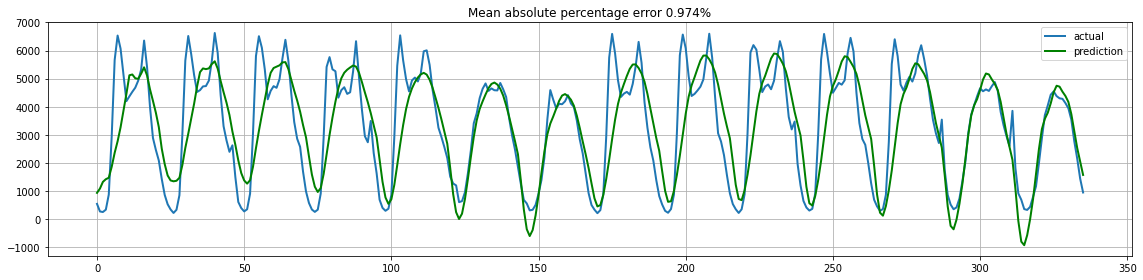

In [32]:
mape = plotRecursivePrediction(linear_model, X_test_df, y_test_df)
results.append(["Lags usage. LinearRegression", mape])

Линейна модель дала в целом тоже дала неплохой результат, но хуже чем со средними. Видимо в силу простоты модели.

In [33]:
from catboost import CatBoostRegressor

cb_model = CatBoostRegressor(iterations=150)

cb_model.fit(X_train_df, y_train_df, verbose=30)

Learning rate set to 0.293437
0:	learn: 1473.3355359	total: 72.8ms	remaining: 10.8s
30:	learn: 273.1143835	total: 469ms	remaining: 1.8s
60:	learn: 236.6062956	total: 865ms	remaining: 1.26s
90:	learn: 218.3426395	total: 1.25s	remaining: 808ms
120:	learn: 204.4784646	total: 1.64s	remaining: 392ms
149:	learn: 194.2615858	total: 2.01s	remaining: 0us


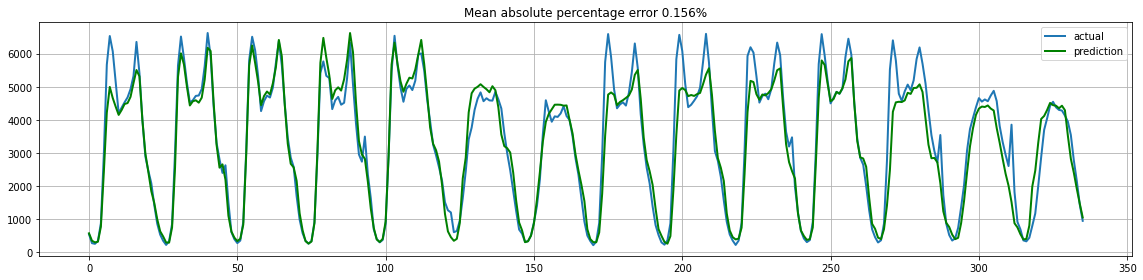

In [34]:
mape = plotRecursivePrediction(cb_model, X_test_df, y_test_df)
results.append(["Lags usage. CatBoost", mape])


Бустерная модель значительно улучшила результат относительно линейной. Но хуже чем по среднему. Вомзожно, тонким тюнингом гиперпараметрорв можно ещё улучшить результат.

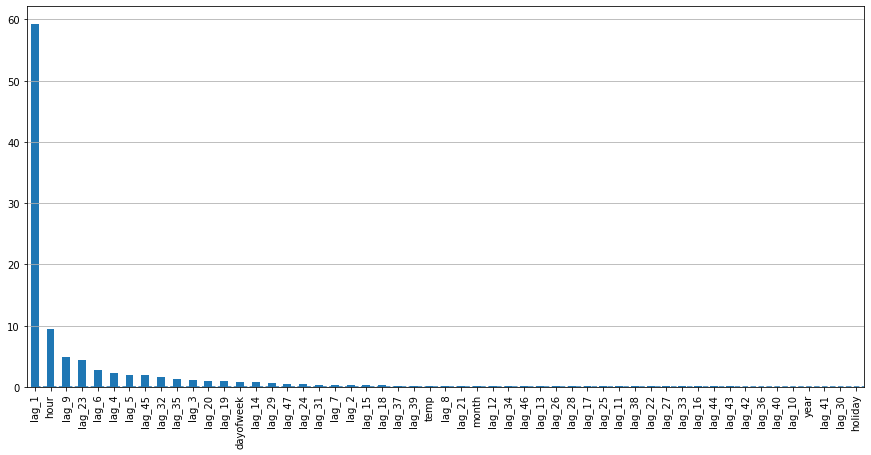

In [35]:
plotCoefficients(cb_model, X_train_df)

Самым важным признаком оказался lag_1, Модель в большей степени операется значение в предыдущий час.
Важность hour говорит, что суточную сезональность модель видит. Об этом же говорит важность lag_23 - значение за сутки.

Learning rate set to 0.293437
0:	learn: 1463.9691201	total: 3.79ms	remaining: 565ms
30:	learn: 264.9496770	total: 71.7ms	remaining: 275ms
60:	learn: 232.9638421	total: 139ms	remaining: 203ms
90:	learn: 221.2212651	total: 207ms	remaining: 134ms
120:	learn: 212.9925070	total: 273ms	remaining: 65.4ms
149:	learn: 206.6499279	total: 337ms	remaining: 0us


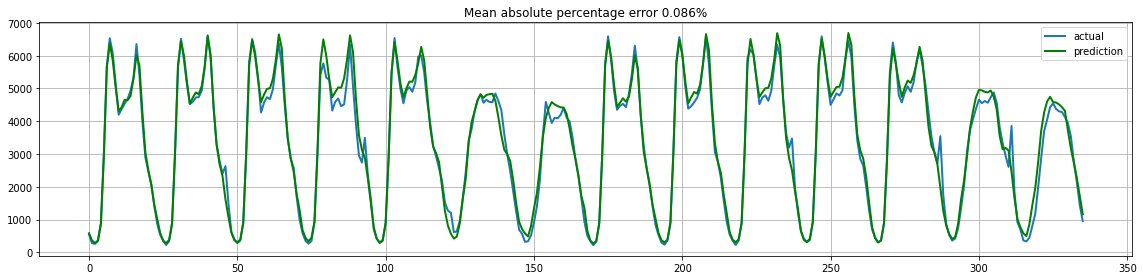

In [36]:
# Уменьшим количество лагов, возьмем самые нужные.
base_cols = ['holiday', 'temp', 'month', 'dayofweek', 'hour', 'year', 'lag_1']
cb_model_2 = CatBoostRegressor(iterations=150)
cb_model_2.fit(X_train_df[base_cols], y_train_df, verbose=30)


mape = plotRecursivePrediction(cb_model_2, X_test_df[base_cols], y_test_df)
results.append(["Lag_1 only. CatBoost", mape])

Чтож, большое количество лагов иногда похоже даже мешает. 

# 3. ARIMA model

In [37]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook

In [38]:
# ARIMA
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    #print(data)
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data.arima_model.append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 6))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data.actual, label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")
    
    plt.legend()
    plt.grid(True)
    return error

In [39]:
sm_df_arima = sm_df.loc['2018-08-20 13:00:00':,:]
train_df, test_df = train_test_split(sm_df_arima[['traffic_volume']], test_size=14*24, shuffle=False)
df_a = sm_df_arima[['traffic_volume']]
#df_a_test = test_df
#df_a_train

In [40]:
%%time
p, d, q = 1, 1, 1
P, D, Q = 0, 1, 0
s = 24*7

model = sm.tsa.statespace.SARIMAX(df_a.traffic_volume,
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


CPU times: user 2min 40s, sys: 34.8 s, total: 3min 15s
Wall time: 1min 44s


CPU times: user 671 ms, sys: 397 ms, total: 1.07 s
Wall time: 539 ms


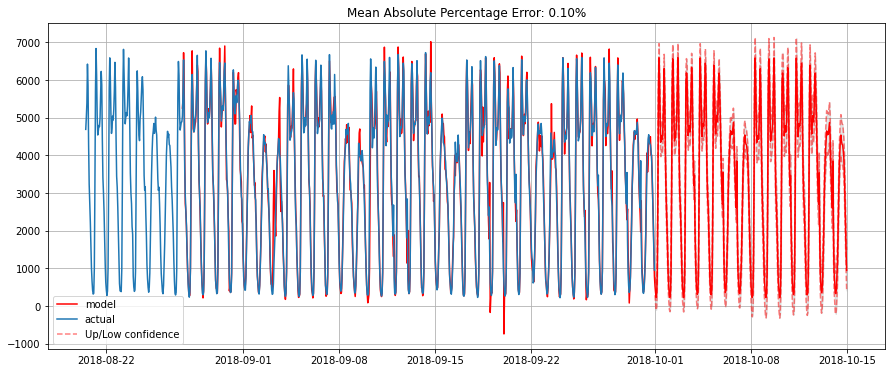

In [41]:
%%time
mape = plotSARIMA(df_a, model, n_steps=14*24, s=s, d=d, plot_intervals=True, alpha=0.5)
results.append(["SARIMA model", mape])

Результат ещё лучше чем у CatBoost. Приближаемся к средним.

# 4. Facebook Prophet

In [42]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


In [43]:
# Подготовим данные
fb_df = pd.DataFrame()
sm_df_ = sm_df.loc['2018-07-30 23:00:00':,:]
fb_df["y"] = sm_df_['traffic_volume']
fb_df["ds"] = sm_df_.index
train_df, test_df = train_test_split(fb_df, test_size=14*24, shuffle=False)

test_y = test_df[['y']]
test_x = test_df[['ds']]

In [44]:
fbmodel = Prophet()
fbmodel.fit(train_df)

Initial log joint probability = -111.917


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       1951.53   2.56535e-05       78.3684   2.685e-07       0.001      142  LS failed, Hessian reset 
      97       1951.53   1.50488e-07       74.2109      0.4008           1      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [45]:
pred = fbmodel.predict(test_x)
pred.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-09-17 00:00:00,3309.597410,-167.251319,1755.869495,3309.597410,3309.597410,-2550.479678,-2550.479678,-2550.479678,-2228.773516,-2228.773516,-2228.773516,-321.706161,-321.706161,-321.706161,0.0,0.0,0.0,759.117732
1,2018-09-17 01:00:00,3309.449484,-903.470153,994.168921,3309.449484,3309.449484,-3184.428458,-3184.428458,-3184.428458,-2892.496353,-2892.496353,-2892.496353,-291.932105,-291.932105,-291.932105,0.0,0.0,0.0,125.021026
2,2018-09-17 02:00:00,3309.301559,-1216.624384,734.487853,3309.301559,3309.301559,-3579.904682,-3579.904682,-3579.904682,-3317.203339,-3317.203339,-3317.203339,-262.701343,-262.701343,-262.701343,0.0,0.0,0.0,-270.603123


In [46]:
# Интеракттивный фирменный плот :)
plot_plotly(fbmodel, pred)

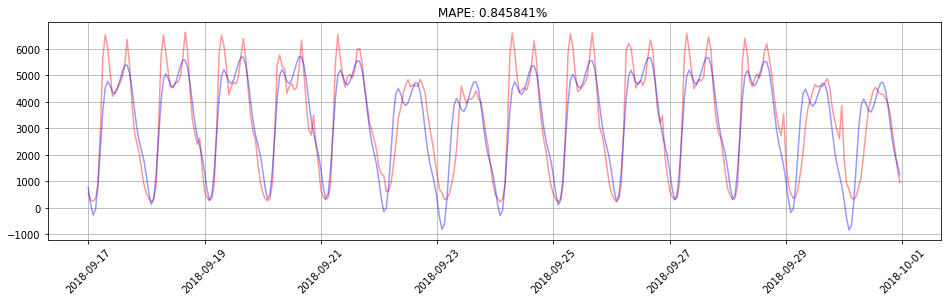

In [47]:
# Классический плот и метрика

mape = mean_absolute_percentage_error(pred['yhat'], test_y)
results.append(["Facebook Prophet", mape])

plt.figure(figsize=(16,4))
plt.plot(test_df["ds"], test_df["y"], c="r", alpha=0.4)
plt.plot(test_df["ds"], pred['yhat'], c="b", alpha=0.4)
plt.xticks(rotation=45)
plt.title("MAPE: {0:2f}% ".format(mape))
plt.grid(True)
plt.show()

Результат хуже чем у предшественников. Думаю, чтобы эффективно использовать этот инструмент надо глубже вникать в настройки.

# 5. Amazon GluonTS

In [48]:
!pip install gluonts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.1 MB/s eta 0:00:00


In [49]:
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.dataset.util import to_pandas

In [50]:
sm_df_gts = sm_df.loc['2018-08-10 13:00:00':,:]
series_train, series_test = train_test_split(sm_df_arima[['traffic_volume']], test_size=14*24, shuffle=False)


In [51]:
training_data = ListDataset(
    [{"start": series_train.traffic_volume.index[0], "target": series_train.traffic_volume.values}],
    freq = "1h"
)

In [52]:
estimator = DeepAREstimator(
    freq="1h", 
    prediction_length=len(series_test), 
    trainer=Trainer(epochs=10)
)
predictor = estimator.train(training_data=training_data)

[10:39:26] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8005 != compiled-against version 8004.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.
100%|██████████| 50/50 [00:23<00:00,  2.09it/s, epoch=10/10, avg_epoch_loss=6.52]


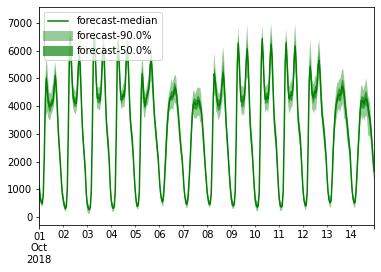

In [53]:
test_data = ListDataset(
    [{"start": series_test.traffic_volume.index[0], "target": series_test.traffic_volume.values}],
    freq = "1h"
)


for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    #to_pandas(test_entry).plot(linewidth=2, figsize=(15, 7), label="historical values")
    test_entry_df = to_pandas(test_entry)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0], label="forecast")

plt.legend(loc='upper left')
plt.grid(axis='x')

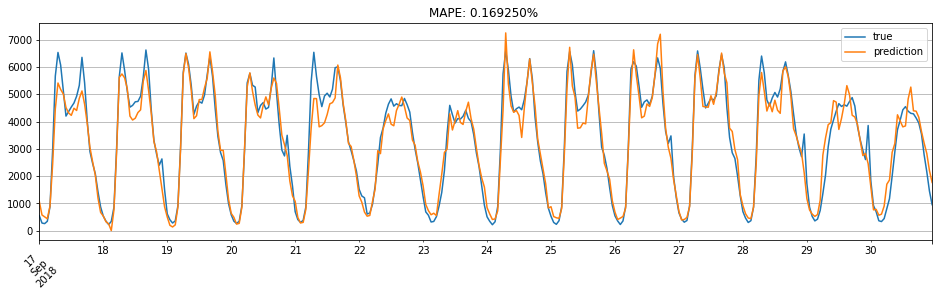

In [54]:
# Классический плот и метрика

mape = mean_absolute_percentage_error(test_entry_df, forecast.samples[0])
results.append([ "Amazon GluonTS", mape])


data_pr = pd.DataFrame(test_entry_df, columns=['true'])
data_pr['prediction'] = forecast.samples[0]

data_pr.plot(figsize=(16,4))
plt.xticks(rotation=45)
plt.title("MAPE: {0:2f}% ".format(mape))
plt.grid(True)
plt.show()


In [55]:
# Сравнение орезультатов работы

pd.DataFrame(results, columns = ["Method", "Mean absolute percentage error"])

,Method,Mean absolute percentage error
0,Forecast by means,0.083921
1,Lags usage. LinearRegression,0.974135
2,Lags usage. CatBoost,0.155733
3,Lag_1 only. CatBoost,0.086402
4,SARIMA model,0.097091
5,Facebook Prophet,0.845841
6,Amazon GluonTS,0.169250


Лучший результат дали SARIMA, CatBoost и обычные средние занчения по дню недели и времени суток.

Общий вывод, можно сделать, что не всегда крутая навороченная модель - это панацея. Для простых последовательностей можно получайть неплохие результаты и простыми методами. Если не получается достичь нужного уровня точности, то уже тогда брать что-то мощное.
